In [86]:
import datetime as dt
from urllib.request import urlopen
import bs4
import re
import pandas as pd

'''
한국거래소 시가총액 상위 10종목
005930 : 삼성전자
000660 : SK하이닉스
068270 : 셀트리온
005380 : 현대차
207940 : 삼성바이오로직스
051910 : LG화학
005490 : POSCO
035420 : NAVER
017670 : SK텔레콤
015760 : 한국전력
'''
k10_component = ['005930', '000660', '068270', '005380', '207940',\
                '051910', '005490','035420', '017670', '015760']

#구성종목 기본정보
def stock_info(stock_cd):
    url_float='http://comp.fnguide.com/SVO2/ASP/SVD_Main.asp?pGB=1&gicode=A'+stock_cd+'&cID=&MenuYn=Y&ReportGB=D&NewMenuID=Y&stkGb=701'
    source = urlopen(url_float).read()
    soup=bs4.BeautifulSoup(source, 'lxml')
    
    #발행주식수 crawl
    #//*[@id="svdMainGrid1"]/table/tbody/tr[7]/td[1]
    tmp = soup.find(id="svdMainGrid1").find_all('tr')[6].find_all('td')[0].text
    tmp = re.split('/', tmp)
    
    outstanding = tmp[0].replace(',', '')
    outstanding = outstanding.replace(' ', '')
    outstanding = int(outstanding)
    
    tmp = soup.find(id="svdMainGrid1").find_all('tr')[6].find_all('td')[1].text
    tmp = re.split('/', tmp)
    
    floating = tmp[1].replace(' ' , '')
    floating = float(floating)
    
    name = soup.find(id='giName').text
    k10_outstanding[stock_cd] = outstanding
    k10_floating[stock_cd] = floating
    k10_name[stock_cd] = name
    
k10_outstanding = dict()
k10_floating = dict()
k10_name = dict()

for stock_cd in k10_component:
    stock_info(stock_cd)
    
tmp = {'Outstanding' : k10_outstanding, \
      'Floating' : k10_floating,\
      'Name' : k10_name}
k10_info = pd.DataFrame(tmp)
k10_info



,Outstanding,Floating,Name
005930,5969782550,74.67,삼성전자
000660,728002365,73.38,SK하이닉스
068270,134939385,75.67,셀트리온
005380,213668187,64.41,현대차
207940,66165000,24.75,삼성바이오로직스
051910,70592343,64.29,LG화학
005490,87186835,68.62,POSCO
035420,164263395,75.66,NAVER
017670,80745711,54.55,SK텔레콤
015760,641964077,44.68,한국전력


In [87]:
#일자별 주가 가져오기
def date_format(d):
    d= str(d)
    d= d.replace('/','-')
    d= d.replace('.','-')
    
    yyyy = int(d.split('-')[0])
    if yyyy< 50:
        yyyy = yyyy+ 2000
    elif yyyy>=50 and yyyy <100:
        yyyy=yyyy+1900
    mm = int(d.split('-')[1])
    dd = int(d.split('-')[2])
    
    return dt.date(yyyy,mm,dd)

def historical_stock_naver(stock_cd, start_date='', end_date='', page_n=1, last_page=0):
    if start_date:
        start_date = date_format(start_date)
    else:
        start_date = dt.date.today()
    if end_date:
        end_date = date_format(end_date)
    else:
        end_date = dt.date.today()
        
    naver_stock="http://finance.naver.com/item/sise_day.nhn?code="+stock_cd+ "&page="+str(page_n)
    
    source = urlopen(naver_stock).read()
    source = bs4.BeautifulSoup(source, 'lxml')
    
    
    dates=source.find_all('span',class_='tah p10 gray03')     #날짜 수집
    prices=source.find_all('td',class_='num')     #종가 수집
    for n in range(len(dates)):
        if len(dates)>0:
            #날짜 처리
            this_date = dates[n].text
            this_date = date_format(this_date)
            if this_date <= end_date and this_date >= start_date:
                
                #종가 처리
                this_close = prices[n*6].text
                this_close = this_close.replace(',','')
                this_close = float(this_close)
            
                #딕셔너리에 저장
                historical_prices[this_date] = this_close
            elif this_date < start_date:
                return historical_prices
    
    #페이지네이션
    if last_page==0:
        last_page = source.find_all('table')[1].find('td', class_='pgRR').find('a')['href']
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page = float(last_page)
    if page_n < last_page:
        page_n = page_n + 1
        historical_stock_naver(stock_cd, start_date, end_date, page_n, last_page)
    
    return historical_prices
    
k10_historical_prices = dict()
for stock_cd in k10_component:
    historical_prices = dict()
    historical_prices = historical_stock_naver(stock_cd, '2020-1-1')
    k10_historical_prices[stock_cd] = historical_prices

    
    #데이터 프레임 형태로 변환
    k10_historical_price = pd.DataFrame(k10_historical_prices)
    k10_historical_price.sort_index(axis=0, inplace=True)

#보간
k10_historical_price = k10_historical_price.fillna(method="ffill")
if k10_historical_price.isnull().values.any():
    k10_historical_price = k10_historical_price.fillna(method="bfill")

    



In [89]:
k10_historical_price

,005930,000660,068270,005380,207940,051910,005490,035420,017670,015760
2020-01-02,55200.0,94700.0,180000.0,118000.0,428500.0,314000.0,236000.0,182500.0,234000.0,28500.0
2020-01-03,55500.0,94500.0,177500.0,116000.0,422000.0,311000.0,237000.0,181500.0,234000.0,28250.0
2020-01-06,55500.0,94300.0,173000.0,116000.0,412000.0,307000.0,231000.0,180500.0,231500.0,27600.0
2020-01-07,55800.0,94000.0,178000.0,115500.0,419000.0,311000.0,232000.0,187000.0,233000.0,27400.0
2020-01-08,56800.0,97400.0,173000.0,112000.0,408500.0,302000.0,228000.0,183000.0,232500.0,26450.0
...,...,...,...,...,...,...,...,...,...,...
2020-07-13,53400.0,83000.0,329000.0,101500.0,730000.0,547000.0,187000.0,297000.0,215500.0,20000.0
2020-07-14,53800.0,82900.0,324000.0,101500.0,735000.0,534000.0,184500.0,287000.0,217500.0,19850.0
2020-07-15,54700.0,83000.0,316000.0,109000.0,749000.0,544000.0,186500.0,286500.0,218000.0,19600.0
2020-07-16,53800.0,82700.0,315000.0,110000.0,732000.0,523000.0,186500.0,273000.0,218000.0,19600.0


In [90]:
#삼성전자 액면분할 반영
k10_historical_price['005930'] = k10_historical_price['005930']/50
k10_historical_price

,005930,000660,068270,005380,207940,051910,005490,035420,017670,015760
2020-01-02,1104.0,94700.0,180000.0,118000.0,428500.0,314000.0,236000.0,182500.0,234000.0,28500.0
2020-01-03,1110.0,94500.0,177500.0,116000.0,422000.0,311000.0,237000.0,181500.0,234000.0,28250.0
2020-01-06,1110.0,94300.0,173000.0,116000.0,412000.0,307000.0,231000.0,180500.0,231500.0,27600.0
2020-01-07,1116.0,94000.0,178000.0,115500.0,419000.0,311000.0,232000.0,187000.0,233000.0,27400.0
2020-01-08,1136.0,97400.0,173000.0,112000.0,408500.0,302000.0,228000.0,183000.0,232500.0,26450.0
...,...,...,...,...,...,...,...,...,...,...
2020-07-13,1068.0,83000.0,329000.0,101500.0,730000.0,547000.0,187000.0,297000.0,215500.0,20000.0
2020-07-14,1076.0,82900.0,324000.0,101500.0,735000.0,534000.0,184500.0,287000.0,217500.0,19850.0
2020-07-15,1094.0,83000.0,316000.0,109000.0,749000.0,544000.0,186500.0,286500.0,218000.0,19600.0
2020-07-16,1076.0,82700.0,315000.0,110000.0,732000.0,523000.0,186500.0,273000.0,218000.0,19600.0


In [96]:
#k10 지수 산출
#유동주식 비율을 반영한 시가총액 구하기

k10_historical_mc = k10_historical_price * k10_info['Outstanding']*k10_info['Floating']*0.01
k10_historical_mc/1000000000000   

,005930,000660,068270,005380,207940,051910,005490,035420,017670,015760
2020-01-02,4.921231,50.589510,18.379554,16.239594,7.017046,14.250519,14.119315,22.681407,10.306948,8.174642
2020-01-03,4.947977,50.482669,18.124282,15.964347,6.910603,14.114367,14.179143,22.557126,10.306948,8.102935
2020-01-06,4.947977,50.375827,17.664793,15.964347,6.746845,13.932832,13.820177,22.432844,10.196831,7.916496
2020-01-07,4.974722,50.215565,18.175337,15.895535,6.861476,14.114367,13.880005,23.240675,10.262901,7.859130
2020-01-08,5.063875,52.031872,17.664793,15.413852,6.689530,13.705913,13.640694,22.743548,10.240878,7.586642
...,...,...,...,...,...,...,...,...,...,...
2020-07-13,4.760756,44.339275,33.593740,13.968803,11.954361,24.824948,11.187762,36.911660,9.492082,5.736591
2020-07-14,4.796417,44.285854,33.083197,13.968803,12.036241,24.234958,11.038193,35.668843,9.580176,5.693567
2020-07-15,4.876654,44.339275,32.266328,15.000981,12.265502,24.688797,11.157849,35.606703,9.602199,5.621859
2020-07-16,4.796417,44.179013,32.164219,15.138605,11.987113,23.735736,11.157849,33.928900,9.602199,5.621859


In [98]:
#비중 계산을 위해 전체 종목의 시가총액의 합을 수한다.
k10 = pd.DataFrame()
k10['Market Cap'] = k10_historical_mc.sum(axis=1)
k10/1000000000000

,Market Cap
2020-01-02,166.679767
2020-01-03,165.690396
2020-01-06,163.998969
2020-01-07,165.479712
2020-01-08,164.781597
...,...
2020-07-13,196.769980
2020-07-14,194.386250
2020-07-15,195.426147
2020-07-16,192.311910


In [109]:
#지수 산출을 위한 기준일
base_date = dt.date(2020,1,2)
k10['Index'] = k10['Market Cap']/k10['Market Cap'][base_date] * 100
k10['Market Cap'] = k10['Market Cap']/1000000000000
k10

,Market Cap,Index
2020-01-02,1.666798e-65,100.000000
2020-01-03,1.656904e-65,99.406424
2020-01-06,1.639990e-65,98.391647
2020-01-07,1.654797e-65,99.280024
2020-01-08,1.647816e-65,98.861188
...,...,...
2020-07-13,1.967700e-65,118.052709
2020-07-14,1.943863e-65,116.622583
2020-07-15,1.954261e-65,117.246473
2020-07-16,1.923119e-65,115.378077


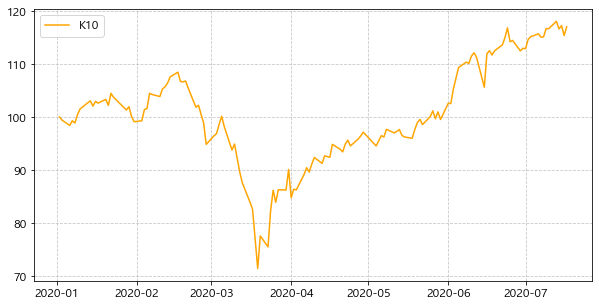

In [110]:
#그래프 그리기
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['font.size']=12
plt.rcParams['axes.unicode_minus']=False

plt.rcParams['figure.figsize']=(10,5)
plt.rcParams['grid.linestyle']='--'
plt.rcParams['grid.alpha']=0.7
plt.rcParams['lines.antialiased']=True

plt.plot(k10['Index'], color='orange', label='K10')
plt.legend(loc=0)
plt.grid(True)

In [111]:
def historical_index_naver(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    if start_date:
        start_date = date_format(start_date)
    else:
        start_date = dt.date.today()
    if end_date:
        end_date = date_format(end_date)
    else:
        end_date = dt.date.today()
        
    naver_index = "http://finance.naver.com/sise/sise_index_day.nhn?code=" + index_cd+ '&page='+ str(page_n)
    
    source = urlopen(naver_index).read()    #지정한 페이지에서 코드 읽기
    source = bs4.BeautifulSoup(source, 'lxml')    #뷰티풀 수프로 태그별로 코드 분류
    
    dates=source.find_all('td',class_='date')     #<td class="date">태그에서 날짜 수집
    prices=source.find_all('td',class_='number_1')     #<td class="number_1">태그에서 지수 수집
    
    for n in range(len(dates)):
        if dates[n].text.split('.')[0].isdigit():
            #날짜 처리
            this_date = dates[n].text
            this_date = date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:
                
                #종가 처리
                this_close = prices[n*4].text
                this_close = this_close.replace(',','')
                this_close = float(this_close)
            
                #딕셔너리에 저장
                historical_prices[this_date] = this_close
            elif this_date < start_date:
                return historical_prices
    
    #페이지네이션
    if last_page==0:
        last_page = source.find('td', class_='pgRR').find('a')['href']
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page = int(last_page)
    if page_n < last_page:
        page_n = page_n + 1
        historical_index_naver(index_cd, start_date, end_date, page_n, last_page)
    
    return historical_prices

index_cd = 'KPI200'
historical_prices=dict()
kospi200 = historical_index_naver(index_cd, '2020-1-2')
k200 = pd.DataFrame({'Index' : kospi200})
k200.head(3)

,Index
2020-01-02,290.35
2020-01-03,290.74
2020-01-06,288.43


In [112]:
#편하게 비교하기 위해 k10 지수를 KOSPI200과 맞춤
k10['Adj Index'] = k10['Market Cap']/k10['Market Cap'][base_date] * k200['Index'][base_date]
k10.tail(3)

,Market Cap,Index,Adj Index
2020-07-15,1.954261e-65,117.246473,340.425133
2020-07-16,1.923119e-65,115.378077,335.000248
2020-07-17,1.950661e-65,117.030463,339.797951


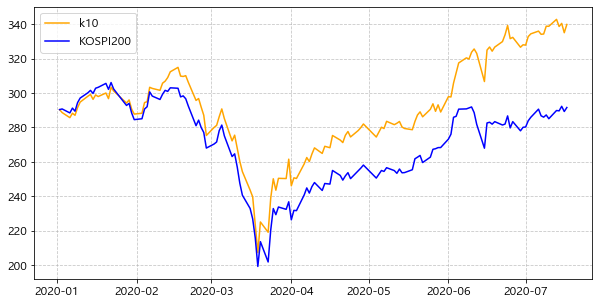

In [113]:
plt.plot(k10['Adj Index'], color='orange', label='k10')
plt.plot(k200['Index'], color='blue', label='KOSPI200')
plt.legend(loc=0)
plt.grid(True)

In [117]:
#k10 펀드 설계 및 운용
import numpy as np

#펀드 기본정보 세팅
CU = 50000 #설정과 환매 단위
base_date = dt.date(2020,1,2) #설정 기준일
volume = 1000000   #최초 설정 수량
interest_rate = 0.02

#설정과 환매가 일어날 경우 랜덤
def creation_redemption(v):
    creation = np.random.randint(0,5)*CU
    if v>500000:
        redemption = np.random.randint(0,5)*CU
    else:
        redemption =0
    volume = v + creation + redemption #총 좌수 = 기존좌수+설정-환매
    return(creation, redemption, volume)

#보유 비중 산정
k10_stock_ratio = pd.DataFrame()
for s in k10_info.index:
    k10_stock_ratio[s] = k10_historical_mc[s]/k10_historical_mc.sum(axis=1)

k10_stock_ratio

,005930,000660,068270,005380,207940,051910,005490,035420,017670,015760
2020-01-02,0.029525,0.303513,0.110269,0.097430,0.042099,0.085496,0.084709,0.136078,0.061837,0.049044
2020-01-03,0.029863,0.304681,0.109386,0.096350,0.041708,0.085185,0.085576,0.136140,0.062206,0.048904
2020-01-06,0.030171,0.307172,0.107713,0.097344,0.041140,0.084957,0.084270,0.136786,0.062176,0.048272
2020-01-07,0.030062,0.303455,0.109834,0.096057,0.041464,0.085294,0.083877,0.140444,0.062019,0.047493
2020-01-08,0.030731,0.315763,0.107201,0.093541,0.040596,0.083176,0.082780,0.138022,0.062148,0.046041
...,...,...,...,...,...,...,...,...,...,...
2020-07-13,0.024195,0.225336,0.170726,0.070991,0.060753,0.126162,0.056857,0.187588,0.048239,0.029154
2020-07-14,0.024675,0.227824,0.170193,0.071861,0.061919,0.124674,0.056785,0.183495,0.049284,0.029290
2020-07-15,0.024954,0.226885,0.165108,0.076760,0.062763,0.126333,0.057095,0.182200,0.049135,0.028767
2020-07-16,0.024941,0.229726,0.167250,0.078719,0.062332,0.123423,0.058020,0.176426,0.049930,0.029233


In [123]:
np.array(k10_stock_ratio.loc[k10_historical_price.index[1]])

array([0.02986278, 0.30468072, 0.10938644, 0.09635047, 0.04170793,
       0.08518519, 0.08557613, 0.13614021, 0.06220607, 0.04890407])

In [125]:
Fund_NAV = pd.DataFrame() #펀드 순자산가치
Fund_Chg = pd.DataFrame() #순자산가치 변화

for d in k10_historical_price.index:
    #포트폴리오 구성용 정보(당일주가, 자산비중)
    stock_price = np.array(k10_historical_price.loc[d])
    stock_weight = np.array(k10_stock_ratio.loc[d])
    
    #기존 주식 포트폴리오 NAV 계산

        
    #기준가격 산정
    if(d<=base_date):
        #최초 기준가를 기준일자의 KOSPI200 지수와 맞춤
        stock_holdings=np.array([0,0,0,0,0,0,0,0,0,0]) #최초 주식 보유량
        NAV_cash = 0 #최초 현금 보유량
        price = k200['Index'][base_date]*100
    else:
        NAV_stock = sum(stock_holdings * stock_price) #주식 잔고
        NAV = NAV_stock + NAV_cash
        price = NAV/volume
        
    
    if (d==base_date):
        volume=0
        volume_chg=1000000
    else:
        vol=creation_redemption(volume)
        volume_chg = vol[0]-vol[1]
    #총 펀드 좌수에 반영
    volume = volume + volume_chg
    #펀드 입출금액
    aum_chg = price*volume_chg
    
    #신규 주식 거래량 계산
    stock_trade = np.floor(aum_chg*stock_weight/stock_price)
    
    #주식 매매 금액
    trade_amt = sum(stock_trade * stock_price)
    #현금 잔고 변동
    cash_chg = aum_chg - trade_amt
    
    #총 주식 보유량 = 기 보유량 + 신규 거래량
    stock_holdings = stock_holdings + stock_trade
    #현금 보유량 증가
    cash_holdings = np.floor(NAV_cash* np.exp(interest_rate/365))
    
    #NAV 업데이트
    NAV_stock = sum(stock_holdings * stock_price)
    NAV_cash = cash_holdings + cash_chg
    NAV = NAV_stock + NAV_cash #전체 잔고
    
    date = pd.Series(d)
    #Fund NAV  정보를 데이터 프레임에 저장
    NAV_tmp = {'Stock' : NAV_stock, 'Cash' : NAV_cash, 'Total' : NAV, 'Price' : price}
    tmp = pd.DataFrame(NAV_tmp, index=date)
    Fund_NAV = Fund_NAV.append(tmp)
    
    #일자별 설정 및 환매 좌수 정보를 데이터 프레임에 저장
    Chg_tmp = {'Amount Change': aum_chg, 'Trade Amount' : trade_amt, 'Cash Change' : cash_chg}
    tmp = pd.DataFrame(Chg_tmp, index=date)
    Fund_Chg = Fund_Chg.append(tmp)


            Amount Change  Trade Amount   Cash Change
2020-01-02   2.903500e+10  2.903382e+10  1.176288e+06
            Amount Change  Trade Amount   Cash Change
2020-01-02   2.903500e+10  2.903382e+10  1.176288e+06
2020-01-03   0.000000e+00  0.000000e+00  0.000000e+00
            Amount Change  Trade Amount   Cash Change
2020-01-02   2.903500e+10  2.903382e+10  1.176288e+06
2020-01-03   0.000000e+00  0.000000e+00  0.000000e+00
2020-01-06  -2.856804e+09 -2.857777e+09  9.726418e+05
            Amount Change  Trade Amount   Cash Change
2020-01-02   2.903500e+10  2.903382e+10  1.176288e+06
2020-01-03   0.000000e+00  0.000000e+00  0.000000e+00
2020-01-06  -2.856804e+09 -2.857777e+09  9.726418e+05
2020-01-07  -1.441298e+09 -1.442259e+09  9.611277e+05
            Amount Change  Trade Amount   Cash Change
2020-01-02   2.903500e+10  2.903382e+10  1.176288e+06
2020-01-03   0.000000e+00  0.000000e+00  0.000000e+00
2020-01-06  -2.856804e+09 -2.857777e+09  9.726418e+05
2020-01-07  -1.441298e+09 -1

            Amount Change  Trade Amount   Cash Change
2020-01-02   2.903500e+10  2.903382e+10  1.176288e+06
2020-01-03   0.000000e+00  0.000000e+00  0.000000e+00
2020-01-06  -2.856804e+09 -2.857777e+09  9.726418e+05
2020-01-07  -1.441298e+09 -1.442259e+09  9.611277e+05
2020-01-08   2.870442e+09  2.869638e+09  8.046516e+05
2020-01-09   0.000000e+00  0.000000e+00  0.000000e+00
2020-01-10   4.420757e+09  4.419666e+09  1.090689e+06
2020-01-13  -4.471924e+09 -4.472684e+09  7.600398e+05
2020-01-14   1.495846e+09  1.494989e+09  8.569687e+05
2020-01-15   4.444716e+09  4.443621e+09  1.094709e+06
2020-01-16   1.494443e+09  1.493585e+09  8.584443e+05
2020-01-17   1.489690e+09  1.488833e+09  8.574000e+05
2020-01-20   0.000000e+00  0.000000e+00  0.000000e+00
2020-01-21   1.483591e+09  1.482736e+09  8.557072e+05
2020-01-22   3.033086e+09  3.032266e+09  8.202232e+05
2020-01-23  -3.011740e+09 -3.012853e+09  1.113236e+06
2020-01-28   2.941715e+09  2.940907e+09  8.078483e+05
2020-01-29   0.000000e+00  0

[64 rows x 3 columns]
            Amount Change  Trade Amount   Cash Change
2020-01-02   2.903500e+10  2.903382e+10  1.176288e+06
2020-01-03   0.000000e+00  0.000000e+00  0.000000e+00
2020-01-06  -2.856804e+09 -2.857777e+09  9.726418e+05
2020-01-07  -1.441298e+09 -1.442259e+09  9.611277e+05
2020-01-08   2.870442e+09  2.869638e+09  8.046516e+05
...                   ...           ...           ...
2020-03-30   2.503364e+09  2.502681e+09  6.824078e+05
2020-03-31   3.923641e+09  3.922556e+09  1.084996e+06
2020-04-01   3.692031e+09  3.691041e+09  9.901842e+05
2020-04-02   0.000000e+00  0.000000e+00  0.000000e+00
2020-04-03   1.251868e+09  1.251092e+09  7.757460e+05

[65 rows x 3 columns]
            Amount Change  Trade Amount   Cash Change
2020-01-02   2.903500e+10  2.903382e+10  1.176288e+06
2020-01-03   0.000000e+00  0.000000e+00  0.000000e+00
2020-01-06  -2.856804e+09 -2.857777e+09  9.726418e+05
2020-01-07  -1.441298e+09 -1.442259e+09  9.611277e+05
2020-01-08   2.870442e+09  2.869638e+

            Amount Change  Trade Amount   Cash Change
2020-01-02   2.903500e+10  2.903382e+10  1.176288e+06
2020-01-03   0.000000e+00  0.000000e+00  0.000000e+00
2020-01-06  -2.856804e+09 -2.857777e+09  9.726418e+05
2020-01-07  -1.441298e+09 -1.442259e+09  9.611277e+05
2020-01-08   2.870442e+09  2.869638e+09  8.046516e+05
...                   ...           ...           ...
2020-05-25  -2.904581e+09 -2.905857e+09  1.275721e+06
2020-05-26  -2.936573e+09 -2.937987e+09  1.413369e+06
2020-05-27  -1.446515e+09 -1.447600e+09  1.085345e+06
2020-05-28   1.465365e+09  1.464383e+09  9.817922e+05
2020-05-29   4.333458e+09  4.332032e+09  1.426290e+06

[101 rows x 3 columns]
            Amount Change  Trade Amount   Cash Change
2020-01-02   2.903500e+10  2.903382e+10  1.176288e+06
2020-01-03   0.000000e+00  0.000000e+00  0.000000e+00
2020-01-06  -2.856804e+09 -2.857777e+09  9.726418e+05
2020-01-07  -1.441298e+09 -1.442259e+09  9.611277e+05
2020-01-08   2.870442e+09  2.869638e+09  8.046516e+05
... 

In [126]:
#펀드 수익률 vs 지수 수익률
Fund_NAV

,Stock,Cash,Total,Price
2020-01-02,2.903382e+10,1.176288e+06,2.903500e+10,29035.000000
2020-01-03,2.886149e+10,1.176352e+06,2.886266e+10,28862.664618
2020-01-06,2.570909e+10,2.149058e+06,2.571124e+10,28568.044682
2020-01-07,2.449895e+10,3.110303e+06,2.450206e+10,28825.955766
2020-01-08,2.726529e+10,3.915125e+06,2.726920e+10,28704.422516
...,...,...,...,...
2020-07-13,2.216097e+10,1.004028e+08,2.226137e+10,34248.252678
2020-07-14,2.358231e+10,1.019907e+08,2.368430e+10,33834.708409
2020-07-15,2.370782e+10,1.019962e+08,2.380982e+10,34014.013488
2020-07-16,2.165608e+10,1.028231e+08,2.175890e+10,33475.219823


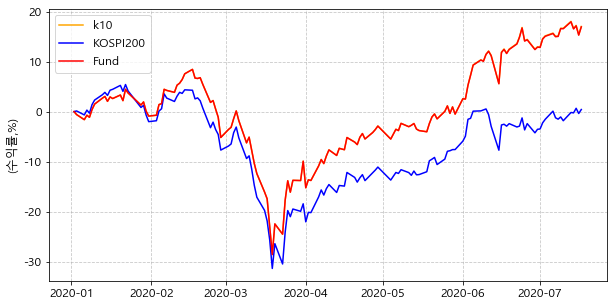

In [128]:
Earnings = pd.DataFrame()
Earnings['k10'] = (k10['Index']-k10['Index'][base_date])/k10['Index'][base_date] * 100

Earnings['KOSPI200'] = (k200['Index']-k200['Index'][base_date])/k200['Index'][base_date]*100
Earnings['Fund'] = (Fund_NAV['Price']-Fund_NAV['Price'][base_date])/Fund_NAV['Price'][base_date]*100
ax = Earnings.plot(color=['orange','blue','red'])
ax.legend(loc=0)
ax.set_ylabel('(수익률,%)')
ax.grid(True)

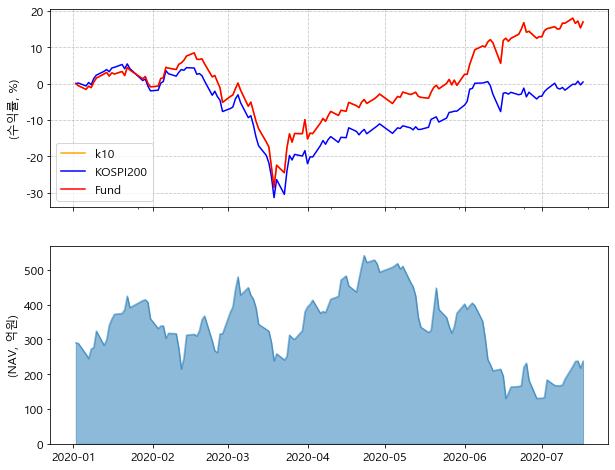

In [129]:
#수익률과 펀드의 NAV(순자산가치)변동을 함께 표시
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
Earnings.plot.line(ax=ax1, color=['orange','b','r'])
ax1.set_ylabel('(수익률, %)')
Fund_NAV['Display'] = Fund_NAV['Total']*0.00000001
Fund_NAV['Display'].plot.area(ax=ax2, stacked=False, sharex=True)
ax2.set_ylabel('(NAV, 억원)')
ax1.grid(True)

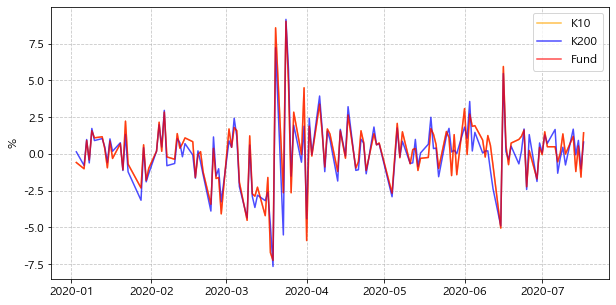

In [130]:
#일간 수익률
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
Daily = pd.DataFrame()
Daily['K10'] = (k10['Index']-k10['Index'].shift(1))/k10['Index'].shift(1)*100
Daily['K200'] = (k200['Index']-k200['Index'].shift(1))/k200['Index'].shift(1)*100
Daily['Fund'] = (Fund_NAV['Price']-Fund_NAV['Price'].shift(1))/Fund_NAV['Price'].shift(1)*100

Daily.plot(ax=ax, color=['orange','blue','red'],alpha=0.7)
ax.set_ylabel('%')
ax.grid(True)

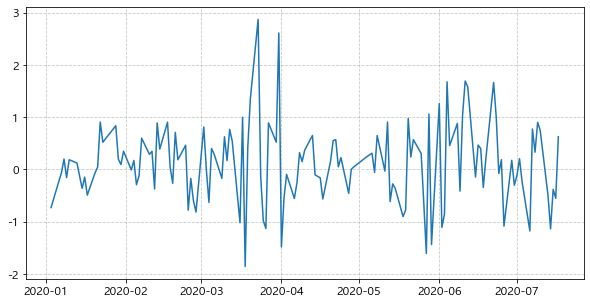

In [131]:
#펀드의 일간 추적오차 = 펀드수익률-지수수익률

fig=plt.figure()
ax=fig.add_subplot(1,1,1)
Daily['TE200'] = Daily['Fund']-Daily['K200']
Daily['TE200'].plot(ax=ax)
ax.grid(True)